In [1]:
from typing import Dict, List, Tuple, Optional, Any, Callable, TypeVar, Union, cast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import linregress
from statsmodels.tsa.stattools import coint, adfuller
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Backend imports
import sys
import os
import json

# Add the parent directory to the system path to allow relative imports
current_file = os.path.abspath('.')  # Get absolute path of current directory
print(f"Current directory: {current_file}")

# Navigate up to project root (4 levels up from the notebook location)
root_dir = os.path.abspath(os.path.join(current_file, '..', '..', '..'))
print(f"Root directory: {root_dir}")
sys.path.append(root_dir)
print(f"Updated sys.path: {sys.path}")

from backend.alpaca.sdk.loaders import (
    get_account, 
    get_positions, 
    get_portfolio_history, 
    get_watchlists,
    get_trading_client
)
from result import Ok, Result, Err
# from sdk.serializers import serialize_position, serialize_account

USE_BACKEND = True

Current directory: /home/cjanua/Documents/repos/Stock-FullStack/StockFullstack/backend/alpaca/research
Root directory: /home/cjanua/Documents/repos/Stock-FullStack/StockFullstack
Updated sys.path: ['/usr/lib/python313.zip', '/usr/lib/python3.13', '/usr/lib/python3.13/lib-dynload', '', '/home/cjanua/Documents/repos/Stock-FullStack/StockFullstack/venv/lib/python3.13/site-packages', '/home/cjanua/Documents/repos/Stock-FullStack/StockFullstack']


In [3]:
PortfolioWeights = pd.Series
PositionType = Dict[str, Any]
WatchlistType = Dict[str, Any]
AccountType = Dict[str, Any]
BacktestResult = Dict[str, Any]
PortfolioInfo = Dict[str, Any]


START_DATE: datetime = datetime(2020, 1, 1)
END_DATE: datetime = datetime.now()
LOOKBACK_DAYS: int = 365  # 1 year of data


In [4]:
# Function to safely handle API results
def handle_api_result(result: Any) -> Any:
    """Process result from the Alpaca API safely"""
    if hasattr(result, 'is_ok') and callable(getattr(result, 'is_ok')):
        if result.is_ok():
            return result.ok_value
        else:
            print(f"API Error: {result.err_value}")
            return None
    return result

In [5]:
if USE_BACKEND:
    # Get current account data
    account_result = get_account()
    account: Optional[AccountType] = handle_api_result(account_result)
    if account:
        print(f"Account: {account['id']}")
        print(f"Portfolio Value: ${float(account['portfolio_value']):,.2f}")
        print(f"Cash: ${float(account['cash']):,.2f}")
        print(f"Buying Power: ${float(account['buying_power']):,.2f}")
    else:
        print("Failed to retrieve account information")
        account = {}

    # Get current positions
    positions_result = get_positions()
    positions: List[PositionType] = handle_api_result(positions_result) or []
    if positions:
        print(f"\nCurrent Positions: {len(positions)}")
        # Convert positions to DataFrame for easier analysis
        positions_df = pd.DataFrame(positions)
        
        # Calculate position weights
        positions_df['market_value'] = positions_df['market_value'].astype(float)
        total_value = positions_df['market_value'].sum()
        positions_df['weight'] = positions_df['market_value'] / total_value
        
        # Display current positions and weights
        display_df = positions_df[['symbol', 'qty', 'avg_entry_price', 'market_value', 'weight']]
        display_df['weight'] = display_df['weight'].map(lambda x: f"{x:.2%}")
        display_df = display_df.sort_values('market_value', ascending=False)
        display(display_df)
    else:
        print("Failed to retrieve positions or no positions found")
        # Create empty DataFrame for positions
        positions_df = pd.DataFrame()

    # Get watchlists
    watchlists_result = get_watchlists()
    watchlists: List[WatchlistType] = handle_api_result(watchlists_result) or []
    if watchlists:
        print(f"\nWatchlists: {len(watchlists)}")
        for watchlist in watchlists:
            assets = watchlist.get('assets', []) or []
            print(f"- {watchlist.get('name', 'Unnamed')}: {len(assets)} assets")
            
            # Extract symbols from watchlist
            if assets:
                watchlist_symbols = [asset.get('symbol', '') for asset in assets if asset.get('symbol')]
                if watchlist_symbols:
                    print(f"  Symbols: {', '.join(watchlist_symbols[:5])}{' ...' if len(watchlist_symbols) > 5 else ''}")
    else:
        print("Failed to retrieve watchlists or no watchlists found")
        # Create empty list for watchlists
        watchlists = []
else:
    # Use synthetic data for testing
    print("Using synthetic data for demonstration")
    
    # Sample account data
    account: AccountType = {
        'id': 'demo-account',
        'portfolio_value': '100000.00',
        'cash': '20000.00',
        'buying_power': '50000.00'
    }
    print(f"Account: {account['id']}")
    print(f"Portfolio Value: ${float(account['portfolio_value']):,.2f}")
    print(f"Cash: ${float(account['cash']):,.2f}")
    print(f"Buying Power: ${float(account['buying_power']):,.2f}")
    
    # Sample positions
    positions: List[PositionType] = [
        {'symbol': 'AAPL', 'qty': '10', 'avg_entry_price': '150.00', 'market_value': '25000.00', 'unrealized_pl': '5000.00'},
        {'symbol': 'MSFT', 'qty': '8', 'avg_entry_price': '250.00', 'market_value': '20000.00', 'unrealized_pl': '3000.00'},
        {'symbol': 'AMZN', 'qty': '5', 'avg_entry_price': '3000.00', 'market_value': '15000.00', 'unrealized_pl': '2000.00'},
        {'symbol': 'GOOGL', 'qty': '6', 'avg_entry_price': '2500.00', 'market_value': '25000.00', 'unrealized_pl': '4000.00'},
        {'symbol': 'META', 'qty': '12', 'avg_entry_price': '300.00', 'market_value': '15000.00', 'unrealized_pl': '1000.00'}
    ]
    
    positions_df = pd.DataFrame(positions)
    positions_df['market_value'] = positions_df['market_value'].astype(float)
    total_value = positions_df['market_value'].sum()
    positions_df['weight'] = positions_df['market_value'] / total_value
    
    print(f"\nCurrent Positions: {len(positions)}")
    display_df = positions_df[['symbol', 'qty', 'avg_entry_price', 'market_value', 'weight']]
    display_df['weight'] = display_df['weight'].map(lambda x: f"{x:.2%}")
    display_df = display_df.sort_values('market_value', ascending=False)
    display(display_df)
    
    # Sample watchlists
    watchlists: List[WatchlistType] = [
        {
            'name': 'Tech Stocks', 
            'assets': [
                {'symbol': 'AAPL'}, {'symbol': 'MSFT'}, {'symbol': 'AMZN'}, 
                {'symbol': 'GOOGL'}, {'symbol': 'META'}, {'symbol': 'TSLA'}, 
                {'symbol': 'NFLX'}, {'symbol': 'NVDA'}
            ]
        },
        {
            'name': 'Financial Stocks',
            'assets': [
                {'symbol': 'JPM'}, {'symbol': 'BAC'}, {'symbol': 'WFC'}, 
                {'symbol': 'GS'}, {'symbol': 'C'}, {'symbol': 'MS'}
            ]
        }
    ]
    
    print(f"\nWatchlists: {len(watchlists)}")
    for watchlist in watchlists:
        print(f"- {watchlist['name']}: {len(watchlist['assets'])} assets")
        watchlist_symbols = [asset['symbol'] for asset in watchlist['assets']]
        print(f"  Symbols: {', '.join(watchlist_symbols[:5])}{' ...' if len(watchlist_symbols) > 5 else ''}")


Returning cached data for key: account
Returning cached data for key: positions


Account: 815ffacb-ddbe-4abf-b5d2-cd9c79b80b53
Portfolio Value: $1,039.93
Cash: $118.68
Buying Power: $118.68

Current Positions: 109


,symbol,qty,avg_entry_price,market_value,weight
103,VOOG,0.402504593,308.071018,137.781347,14.96%
102,VOO,0.245159145,481.32,127.808817,13.87%
104,VOOV,0.66200644,178.246,122.385131,13.28%
85,SPY,0.199773496,525.595245,113.297543,12.30%
7,AMD,0.853096741,117.118,91.324006,9.91%
...,...,...,...,...,...
35,FL,0.045776021,20.58,0.757135,0.08%
106,W,0.02358674,42.41,0.754540,0.08%
33,ELF,0.010883934,75.47,0.695919,0.08%
61,MRP,0.00555387,0,0.141013,0.02%


Returning cached data for key: watchlists



Watchlists: 2
- Primary: 0 assets
- Primary Watchlist: 0 assets


 ## Step 2: Define the Universe of Stocks
 
 Next, we'll create a universe of stocks to analyze by combining:
 1. Currently held positions
 2. Stocks in watchlists

 This will be our universe for portfolio optimization.



In [6]:
#  Extract symbols from positions
position_symbols: List[str] = positions_df['symbol'].tolist() if not positions_df.empty else []

# Extract symbols from watchlists
watchlist_symbols: List[str] = []
for watchlist in watchlists:
    assets = watchlist.get('assets', []) or []
    for asset in assets:
        symbol = asset.get('symbol')
        if symbol:
            watchlist_symbols.append(symbol)

universe: List[str] = list(set(position_symbols + watchlist_symbols))
# If universe is empty, use a default set of popular stocks
if not universe:
    universe = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NFLX", "NVDA", "JPM", "V"]
    print("No positions or watchlist items found. Using default stock universe.")

print(f"Analysis Universe: {len(universe)} symbols")



Analysis Universe: 109 symbols


In [7]:
def get_historical_data(symbols: List[str], start_date: datetime, end_date: datetime) -> Optional[pd.DataFrame]:
    """
    Retrieve historical price data for a list of symbols using yfinance
    
    Parameters:
        symbols: List of stock symbols to retrieve data for
        start_date: Start date for the historical data
        end_date: End date for the historical data
        
    Returns:
        DataFrame with historical price data or None if retrieval fails
    """
    try:
        import yfinance as yf
        
        # Download data for all symbols
        data = yf.download(symbols, start=start_date, end=end_date, progress=False)
        if data.empty:
            return None
            
        print(f"Retrieved data from {data.index[0].date()} to {data.index[-1].date()}")
        
        return data
    except ImportError:
        print("yfinance not installed. Using synthetic data.")
        return None
    except Exception as e:
        print(f"Error retrieving historical data: {e}")
        return None


In [8]:
print(f"Retrieving historical data for {len(universe)} symbols...")
history: Optional[pd.DataFrame] = get_historical_data(universe, START_DATE, END_DATE)


Retrieving historical data for 109 symbols...
YF.download() has changed argument auto_adjust default to True


2025-03-19 21:45:50,489 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2025-03-19 21:45:50,572 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2025-03-19 21:45:50,576 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2025-03-19 21:45:51,096 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2025-03-19 21:45:51,561 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2025-03-19 21:45:52,047 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 9
2025-03-19 21:45:52,436 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2025-03-19 21:45:52,441 - WARNING - Connection pool is f

Retrieved data from 2020-01-02 to 2025-03-19


In [9]:
print(history.head(1))
close_prices = history[('Close', 'AAPL')]
    
# Check for missing data
missing_data = close_prices.isna().sum()
symbols_with_missing: np.ndarray = missing_data[missing_data > 0]
if symbols_with_missing is not None and symbols_with_missing.size > 0:
    print(f"Symbols with missing data:")
    print(symbols_with_missing)
    
    # Remove symbols with too much missing data (>20%)
    threshold = len(close_prices) * 0.2
    symbols_to_remove = symbols_with_missing[symbols_with_missing > threshold].index.tolist()
    if symbols_to_remove:
        print(f"Removing {len(symbols_to_remove)} symbols with >20% missing data: {symbols_to_remove}")
        close_prices = close_prices.drop(columns=symbols_to_remove)
        universe = [sym for sym in universe if sym not in symbols_to_remove]
        
# Fill remaining NaN values with forward fill then backward fill
close_prices = close_prices.fillna(method='ffill').fillna(method='bfill')

# Calculate daily returns
returns = close_prices.pct_change().dropna()
print(f"Final analysis universe: {len(universe)} symbols")


Price           Close                                                \
Ticker           AAPL  ACEL        ADBE       ADT        AEO    AGS   
Date                                                                  
2020-01-02  72.716064  12.5  334.429993  6.749928  12.775582  12.12   

Price                                                   ... Volume          \
Ticker            ALV        AMD       AMZN       ANDE  ...   URNM     UTI   
Date                                                    ...                  
2020-01-02  77.072678  49.099998  94.900497  22.340168  ...   8200  102100   

Price                                                                        
Ticker     UTZ      VOO    VOOG    VOOV      VVV        W    WING       XLK  
Date                                                                         
2020-01-02   0  3142400  106800  139300  1041000  1882500  821200  13283500  

[1 rows x 545 columns]
Final analysis universe: 109 symbols


In [10]:
# Check if history is not None and has data
from pypfopt import EfficientFrontier, expected_returns, risk_models

if history is not None and not history.empty:
    # Display the first row of the dataframe
    print("Data Preview:")
    display(history.head(1))
    
    # Print column structure for debugging
    print("Column structure:", type(history.columns))
    print(history.columns)
    
    # Extract close prices, keeping multi-index structure intact
    # We know from the structure that level 0 contains 'Close' and level 1 contains symbols
    if isinstance(history.columns, pd.MultiIndex):
        # Get all symbols from the second level of the multi-index
        symbols = history.columns.get_level_values(1).unique().tolist()
        universe = symbols  # Set universe to available symbols
        
        # Extract close prices using the multi-index directly
        close_prices = history['Close']
    else:
        # Fallback if not multi-index
        close_prices = history['Close']
        universe = close_prices.columns.tolist()
    
    print(f"Initial universe: {len(universe)} symbols")
    
    # Check for missing data
    missing_data = close_prices.isna().sum()
    symbols_with_missing = missing_data[missing_data > 0]
    if not symbols_with_missing.empty:
        print(f"Symbols with missing data:")
        print(symbols_with_missing)

        # Remove symbols with too much missing data (>20%)
        threshold = len(close_prices) * 0.2
        symbols_to_remove = symbols_with_missing[symbols_with_missing > threshold].index.tolist()
        if symbols_to_remove:
            print(f"Removing {len(symbols_to_remove)} symbols with >20% missing data: {symbols_to_remove}")
            close_prices = close_prices.drop(columns=symbols_to_remove)
            universe = [sym for sym in universe if sym not in symbols_to_remove]

    # Fill remaining NaN values with forward fill then backward fill
    close_prices = close_prices.fillna(method='ffill').fillna(method='bfill')
    
    # Check if we still have a valid universe after filtering
    if len(universe) == 0:
        print("Error: All symbols were filtered out due to missing data.")
        print("This may indicate an issue with API credentials or market data access.")
        raise ValueError("No valid symbols in universe after filtering")
    
    # Calculate daily returns
    returns = close_prices.pct_change().dropna()
    print(f"Final analysis universe: {len(universe)} symbols")
    
    # Continue only if we have enough data
    if len(universe) >= 2:  # Need at least 2 stocks for a portfolio
        # Calculate expected returns and sample covariance matrix
        mu = expected_returns.mean_historical_return(close_prices)
        S = risk_models.sample_cov(close_prices)
        
        # Verify mu and S are not empty
        if len(mu) > 0 and S.shape[0] > 0:
            # Optimize for maximum Sharpe ratio
            ef = EfficientFrontier(mu, S)
            weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
            print("Optimized Weights:")
            print(cleaned_weights)

            # Get the performance of the optimized portfolio
            performance = ef.portfolio_performance(verbose=True)
        else:
            print("Error: Empty return or covariance matrix after processing.")
    else:
        print("Error: Not enough valid symbols for portfolio optimization (minimum 2 required).")
else:
    print("Historical data is not available or empty.")

Data Preview:


Price           Close                                                \
Ticker           AAPL  ACEL        ADBE       ADT        AEO    AGS   
Date                                                                  
2020-01-02  72.716064  12.5  334.429993  6.749928  12.775582  12.12   

Price                                                   ... Volume          \
Ticker            ALV        AMD       AMZN       ANDE  ...   URNM     UTI   
Date                                                    ...                  
2020-01-02  77.072678  49.099998  94.900497  22.340168  ...   8200  102100   

Price                                                                        
Ticker     UTZ      VOO    VOOG    VOOV      VVV        W    WING       XLK  
Date                                                                         
2020-01-02   0  3142400  106800  139300  1041000  1882500  821200  13283500  

[1 rows x 545 columns]

Column structure: <class 'pandas.core.indexes.multi.MultiIndex'>
MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'ACEL'),
            ( 'Close', 'ADBE'),
            ( 'Close',  'ADT'),
            ( 'Close',  'AEO'),
            ( 'Close',  'AGS'),
            ( 'Close',  'ALV'),
            ( 'Close',  'AMD'),
            ( 'Close', 'AMZN'),
            ( 'Close', 'ANDE'),
            ...
            ('Volume', 'URNM'),
            ('Volume',  'UTI'),
            ('Volume',  'UTZ'),
            ('Volume',  'VOO'),
            ('Volume', 'VOOG'),
            ('Volume', 'VOOV'),
            ('Volume',  'VVV'),
            ('Volume',    'W'),
            ('Volume', 'WING'),
            ('Volume',  'XLK')],
           names=['Price', 'Ticker'], length=545)
Initial universe: 109 symbols
Symbols with missing data:
Ticker
ARHS     465
COIN     322
MRP     1280
PHIN     881
REYN      20
dtype: int64
Removing 4 symbols with >20% missing data: ['ARHS', 'COIN', 'MRP', 'PHIN']
Final analy

In [11]:
for v in cleaned_weights.items():
    tick = v[0]
    weight = v[1]
    if weight > 0:
        print(f"{tick} - {weight:.2f}")

CASY - 0.04
COST - 0.14
DDS - 0.03
GLD - 0.47
GPI - 0.00
LAKE - 0.01
NVDA - 0.20
TSCO - 0.09
UTI - 0.02


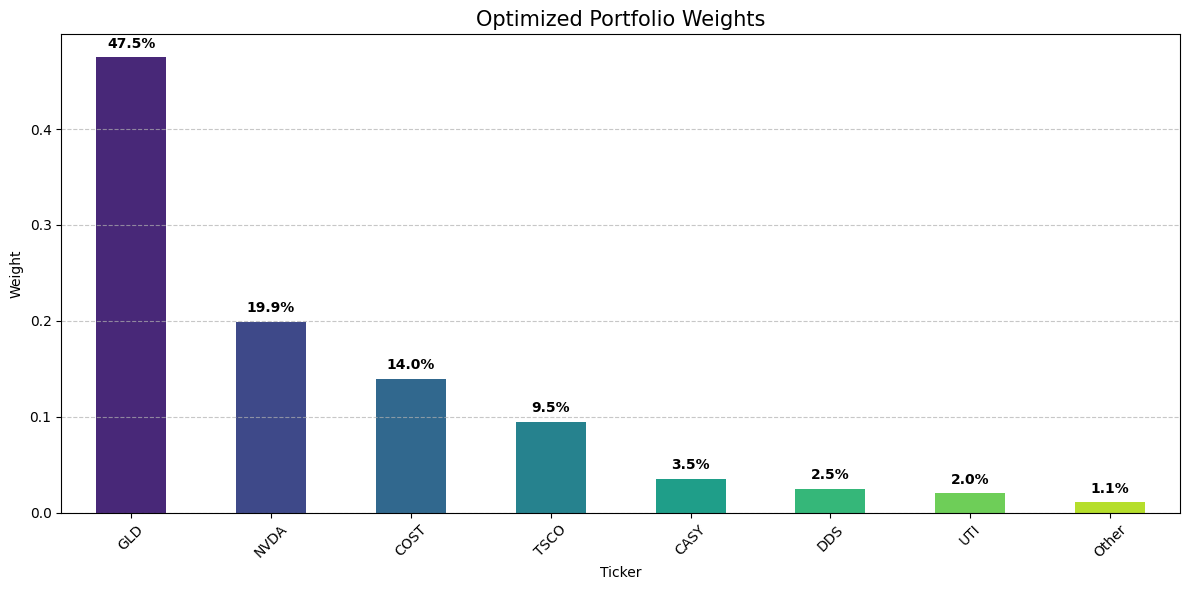

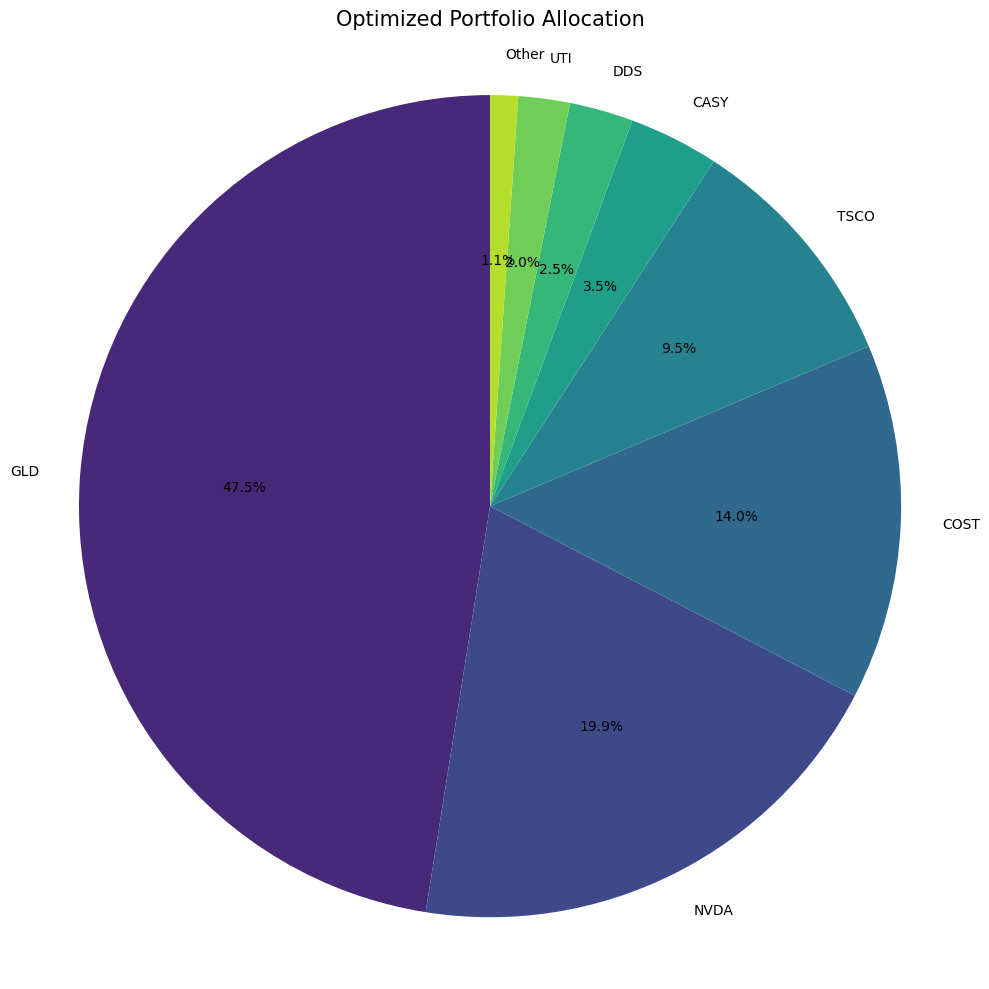

In [12]:

## 1. Visualize Optimized Portfolio Weights
# Create a visualization of the optimized weights
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out weights close to zero for better visualization
significant_weights = {k: v for k, v in cleaned_weights.items() if v > 0.01}
other_weight = sum(v for k, v in cleaned_weights.items() if v <= 0.01)

# Add the 'Other' category if needed
if other_weight > 0:
    significant_weights['Other'] = other_weight

# Convert to Series and sort by value
weight_series = pd.Series(significant_weights).sort_values(ascending=False)

# Bar chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("viridis", len(weight_series))
ax = weight_series.plot(kind='bar', color=colors)

# Add value labels on top of bars
for i, v in enumerate(weight_series):
    ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

plt.title('Optimized Portfolio Weights', fontsize=15)
plt.ylabel('Weight')
plt.xlabel('Ticker')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(10, 10))
plt.pie(weight_series, labels=weight_series.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette("viridis", len(weight_series)))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Optimized Portfolio Allocation', fontsize=15)
plt.tight_layout()
plt.show()


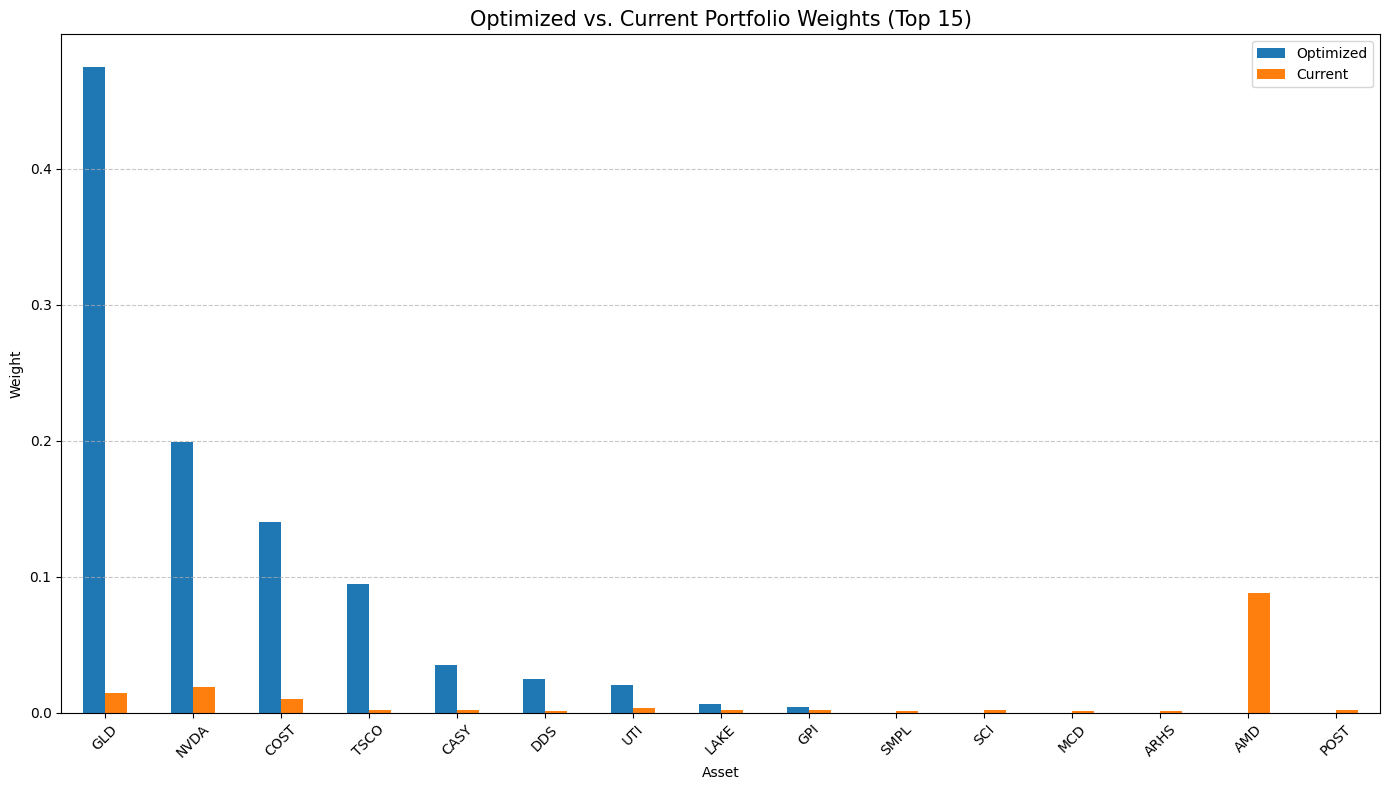

Top Assets to Buy:


,Optimized,Current,Difference,$ Amount
GLD,0.47496,0.014473,0.460487,478.874665
NVDA,0.1988,0.018893,0.179907,187.091027
COST,0.13984,0.009681,0.130159,135.356537
TSCO,0.09479,0.001609,0.093181,96.901471
CASY,0.03534,0.00181,0.03353,34.868698



Top Assets to Sell:


,Optimized,Current,Difference,$ Amount
AMD,0.0,0.087817,-0.087817,-91.324006


In [13]:
## 2. Compare Optimized vs. Current Portfolio Weights
# Get current positions from the positions data
# First, create a dictionary of current positions by symbol
positions_dict = {}
current_portfolio_value = float(account['portfolio_value'])
cash_value = float(account['cash'])
invested_value = current_portfolio_value - cash_value

for pos in positions_df.to_dict('records'):
    symbol = pos['symbol']
    market_value = float(pos['market_value'])
    # Calculate weight as percentage of total portfolio value
    weight = market_value / current_portfolio_value
    positions_dict[symbol] = weight

# Also consider cash position
positions_dict['CASH'] = cash_value / current_portfolio_value

# Create a comparison DataFrame
all_assets = list(set(cleaned_weights.keys()).union(set(positions_dict.keys())))  # Convert set to list
comparison_df = pd.DataFrame(index=all_assets, columns=['Optimized', 'Current'])

for asset in all_assets:
    comparison_df.loc[asset, 'Optimized'] = cleaned_weights.get(asset, 0)
    comparison_df.loc[asset, 'Current'] = positions_dict.get(asset, 0)

# Sort by optimized weights
comparison_df = comparison_df.sort_values('Optimized', ascending=False)
comparison_df = comparison_df.head(15)  # Show top 15 for readability

# Plot the comparison
plt.figure(figsize=(14, 8))
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('Optimized vs. Current Portfolio Weights (Top 15)', fontsize=15)
plt.ylabel('Weight')
plt.xlabel('Asset')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate rebalancing requirements
rebalance_df = comparison_df.copy()
rebalance_df['Difference'] = rebalance_df['Optimized'] - rebalance_df['Current']
rebalance_df['Action'] = rebalance_df['Difference'].apply(
    lambda x: 'Buy' if x > 0.01 else ('Sell' if x < -0.01 else 'Hold')
)
rebalance_df['$ Amount'] = rebalance_df['Difference'] * current_portfolio_value

# Show top buys and sells
buys = rebalance_df[rebalance_df['Action'] == 'Buy'].sort_values('Difference', ascending=False)
sells = rebalance_df[rebalance_df['Action'] == 'Sell'].sort_values('Difference')

print("Top Assets to Buy:")
display(buys[['Optimized', 'Current', 'Difference', '$ Amount']].head(5))

print("\nTop Assets to Sell:")
display(sells[['Optimized', 'Current', 'Difference', '$ Amount']].head(5))

Returning cached data for key: portfolio_history_365_1D



Real Portfolio Verification:
Initial Value: $308.42
Final Value: $1024.68
Total Return: 232.24%


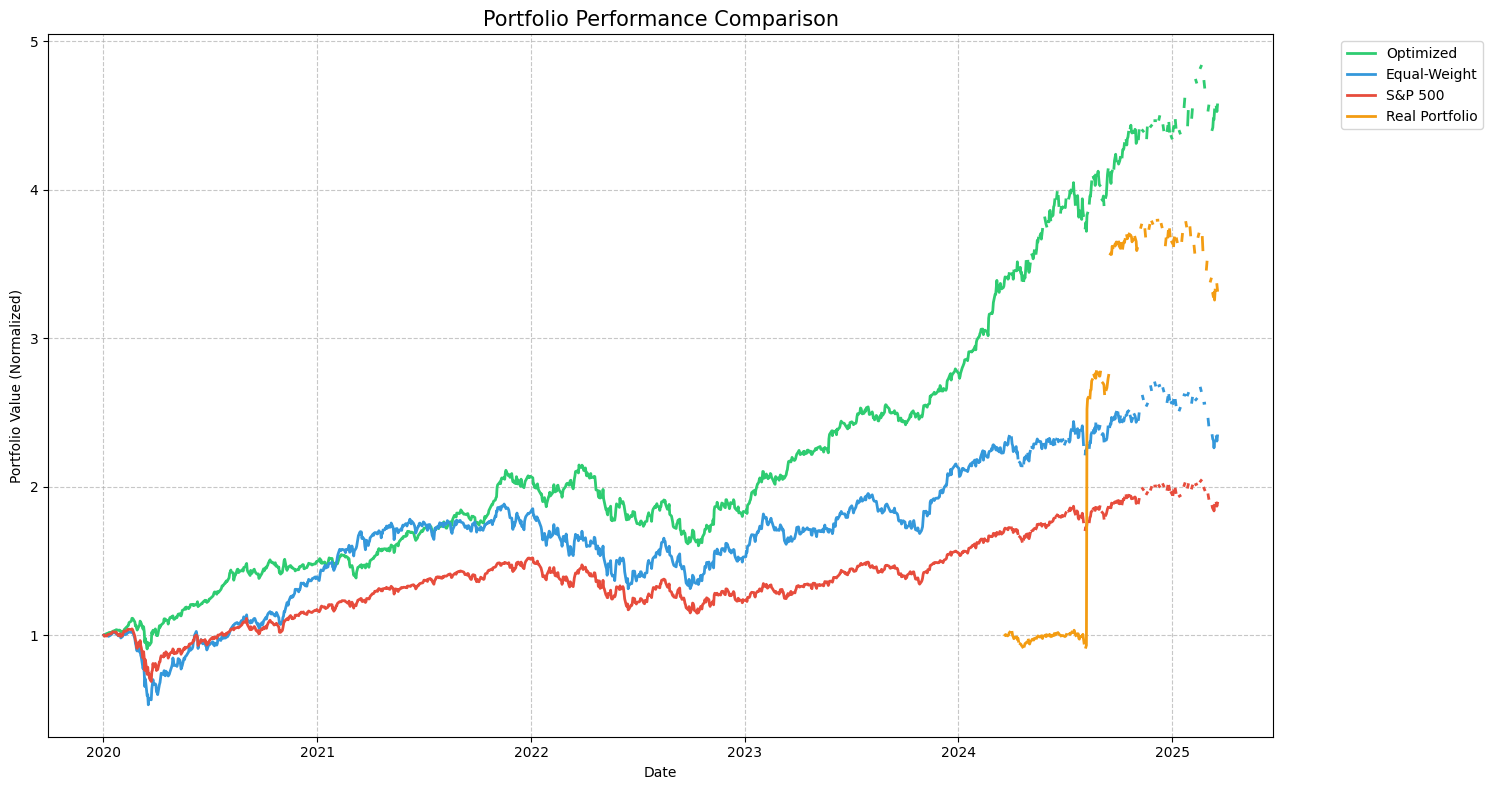


Performance Metrics:


,Optimized,Equal-Weight,S&P 500,Real Portfolio
Total Return (%),357.08,134.16,88.81,NaN
Annual Volatility (%),17.50,26.58,20.21,143.91
Sharpe Ratio,1.62,0.70,0.66,0.93
Max Drawdown (%),-25.36,-48.28,-33.99,-14.84
Information Ratio vs S&P,1.17,0.40,NaN,0.89



Analysis Period:
Start Date: 2020-01-02
End Date: 2025-03-19
Total Days: 1430


In [14]:
def get_historical_comparison(history, initial_weights, days=365, timeframe='1D'):
    # First, properly extract close prices for all symbols
    close_prices = history.xs('Close', level=0, axis=1)
    
    # Get real portfolio history from Alpaca
    portfolio_history_result = get_portfolio_history(days, timeframe)
    if portfolio_history_result.is_err():
        print(f"Error getting portfolio history: {portfolio_history_result.err_value}")
        return
    
    real_history = portfolio_history_result.ok_value
    
    # Create DataFrame with just equity values
    real_df = pd.DataFrame({
        'equity': pd.to_numeric(real_history['equity'], errors='coerce')
    }, index=pd.to_datetime(real_history['timestamp'], unit='s'))
    
    # Calculate Real Portfolio performance simply from equity values
    real_df['Real Portfolio'] = real_df['equity'] / real_df['equity'].iloc[0]
    
    # Print verification of real portfolio values
    print("\nReal Portfolio Verification:")
    print(f"Initial Value: ${real_df['equity'].iloc[0]:.2f}")
    print(f"Final Value: ${real_df['equity'].iloc[-1]:.2f}")
    print(f"Total Return: {((real_df['equity'].iloc[-1] / real_df['equity'].iloc[0]) - 1) * 100:.2f}%")
    
    # Calculate other portfolios as before
    prices_filled = close_prices.fillna(method='ffill')
    returns = prices_filled.pct_change()
    returns = returns.fillna(0)
    
    # Initialize portfolio values DataFrame
    portfolio_values = pd.DataFrame(index=returns.index)
    
    # Calculate optimized portfolio returns
    optimized_returns = pd.Series(0, index=returns.index)
    total_investment = sum(float(val) for val in initial_weights.values())
    
    for symbol, weight in initial_weights.items():
        if symbol in returns.columns:
            normalized_weight = float(weight) / total_investment
            optimized_returns += returns[symbol] * normalized_weight
    
    portfolio_values['Optimized'] = (1 + optimized_returns).cumprod()
    
    # Calculate equal-weight buy and hold returns
    valid_symbols = [symbol for symbol in initial_weights.keys() if symbol in returns.columns]
    equal_weight = 1.0 / len(valid_symbols)
    equal_weight_returns = pd.Series(0, index=returns.index)
    
    for symbol in valid_symbols:
        equal_weight_returns += returns[symbol] * equal_weight
    
    portfolio_values['Equal-Weight'] = (1 + equal_weight_returns).cumprod()
    
    # Calculate S&P 500 returns using VOO
    if 'VOO' in returns.columns:
        portfolio_values['S&P 500'] = (1 + returns['VOO']).cumprod()
    
    # Normalize simulated portfolios to start at 1
    portfolio_values = portfolio_values.div(portfolio_values.iloc[0])
    
    # Combine the dataframes
    combined_df = pd.concat([portfolio_values, real_df[['Real Portfolio']]], axis=1)
    
    # Visualization with distinct colors
    plt.figure(figsize=(15, 8))
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
    
    for i, column in enumerate(combined_df.columns):
        plt.plot(combined_df.index, combined_df[column], label=column, color=colors[i], linewidth=2)
    
    plt.title('Portfolio Performance Comparison', fontsize=15)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Normalized)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Calculate performance metrics
    metrics = [
        'Total Return (%)', 
        'Annual Volatility (%)', 
        'Sharpe Ratio', 
        'Max Drawdown (%)',
        'Information Ratio vs S&P'
    ]
    performance_metrics = pd.DataFrame(index=metrics)

    sp500_returns = None
    if 'S&P 500' in combined_df.columns:
        sp500_returns = combined_df['S&P 500'].pct_change().dropna()

    for column in combined_df.columns:
        returns_series = combined_df[column].pct_change().dropna()
        total_return = (combined_df[column].iloc[-1] / combined_df[column].iloc[0] - 1) * 100
        annual_vol = returns_series.std() * np.sqrt(252) * 100
        sharpe = (returns_series.mean() / returns_series.std()) * np.sqrt(252)
        
        # Calculate maximum drawdown
        cum_returns = (1 + returns_series).cumprod()
        rolling_max = cum_returns.expanding().max()
        drawdowns = (cum_returns - rolling_max) / rolling_max
        max_drawdown = drawdowns.min() * 100
        
        # Calculate Information Ratio vs S&P 500
        if sp500_returns is not None and column != 'S&P 500':
            excess_returns = returns_series - sp500_returns
            info_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
        else:
            info_ratio = np.nan
        
        performance_metrics[column] = [
            total_return,
            annual_vol,
            sharpe,
            max_drawdown,
            info_ratio
        ]

    print("\nPerformance Metrics:")
    display(performance_metrics.round(2))

    # Print time period analysis
    print(f"\nAnalysis Period:")
    print(f"Start Date: {combined_df.index[0].strftime('%Y-%m-%d')}")
    print(f"End Date: {combined_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total Days: {len(combined_df)}")

# Run the comparison
get_historical_comparison(history, cleaned_weights)